In [2]:
import pandas as pd
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import scipy.stats as stats

In [3]:
filename = "2021-2022_NBA_Player_Stats.csv"
df = pd.read_csv(filename,index_col=0, encoding = "ISO-8859-1",  sep=';')
df.head(9)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Rk,,,,,,,,,,,,,,,,,,,,,
1,Precious Achiuwa,C,22,TOR,48,23,23.1,3.1,7.3,0.423,...,0.579,2.2,4.7,6.9,1.1,0.5,0.6,1.0,2.0,7.5
2,Steven Adams,C,28,MEM,56,55,26.1,2.8,5.0,0.546,...,0.556,4.5,5.1,9.6,3.2,0.9,0.7,1.6,1.9,7.0
3,Bam Adebayo,C,24,MIA,33,33,33.0,7.2,13.6,0.527,...,0.764,2.8,7.4,10.2,3.5,1.5,0.6,2.9,3.2,18.7
4,Santi Aldama,PF,21,MEM,27,0,10.3,1.4,3.6,0.381,...,0.600,0.9,1.5,2.4,0.5,0.1,0.3,0.3,1.0,3.3
5,LaMarcus Aldridge,C,36,BRK,38,11,22.8,5.8,10.5,0.558,...,0.844,1.6,4.2,5.8,0.8,0.3,1.1,1.0,1.7,13.7
6,Nickeil Alexander-Walker,SG,23,TOT,52,19,25.4,4.6,12.2,0.374,...,0.722,0.7,2.5,3.2,2.7,0.8,0.4,1.6,1.7,12.3
6,Nickeil Alexander-Walker,SG,23,NOP,50,19,26.3,4.7,12.6,0.375,...,0.722,0.7,2.6,3.3,2.8,0.8,0.4,1.7,1.8,12.8
6,Nickeil Alexander-Walker,SG,23,UTA,2,0,2.5,0.0,0.5,0.000,...,0.000,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0
7,Grayson Allen,SG,26,MIL,49,48,28.0,4.0,9.4,0.425,...,0.857,0.5,2.9,3.4,1.5,0.8,0.3,0.6,1.4,11.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 734 entries, 1 to 592
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  734 non-null    object 
 1   Pos     734 non-null    object 
 2   Age     734 non-null    int64  
 3   Tm      734 non-null    object 
 4   G       734 non-null    int64  
 5   GS      734 non-null    int64  
 6   MP      734 non-null    float64
 7   FG      734 non-null    float64
 8   FGA     734 non-null    float64
 9   FG%     734 non-null    float64
 10  3P      734 non-null    float64
 11  3PA     734 non-null    float64
 12  3P%     734 non-null    float64
 13  2P      734 non-null    float64
 14  2PA     734 non-null    float64
 15  2P%     734 non-null    float64
 16  eFG%    734 non-null    float64
 17  FT      734 non-null    float64
 18  FTA     734 non-null    float64
 19  FT%     734 non-null    float64
 20  ORB     734 non-null    float64
 21  DRB     734 non-null    float64
 22  TR

In [5]:
df.describe()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,...,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,26.044959,28.279292,12.915531,18.114169,2.855586,6.401907,0.420251,0.868801,2.572071,0.274554,...,0.633832,0.810899,2.540736,3.349455,1.775749,0.576158,0.361717,0.979428,1.539782,7.727520
std,4.092637,19.514704,18.423425,9.995226,2.288435,4.781059,0.161695,0.879551,2.292469,0.175847,...,0.305932,0.760459,1.870797,2.438201,1.841861,0.447355,0.392693,0.834717,0.844562,6.265428
min,19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,6.250000,0.000000,9.725000,1.100000,2.800000,0.375000,0.100000,0.700000,0.182000,...,0.563000,0.300000,1.225000,1.600000,0.500000,0.300000,0.100000,0.400000,1.000000,3.000000
50%,25.000000,31.000000,3.000000,17.000000,2.400000,5.100000,0.436000,0.600000,2.000000,0.320000,...,0.748000,0.600000,2.300000,2.950000,1.100000,0.500000,0.300000,0.800000,1.600000,6.300000
75%,29.000000,46.000000,20.000000,26.475000,4.000000,8.900000,0.497250,1.400000,3.900000,0.375000,...,0.833000,1.100000,3.400000,4.500000,2.300000,0.800000,0.500000,1.300000,2.200000,10.675000
max,41.000000,60.000000,60.000000,39.000000,11.000000,21.400000,1.000000,4.600000,12.300000,1.000000,...,1.000000,4.500000,11.300000,14.800000,11.000000,2.300000,3.000000,4.800000,4.000000,29.400000


In [6]:
df.loc[df["Player"] == "Nikola Joki?", "Player"] = 'Nikola Jokic'
df.loc[df["Player"] == "Luka Don?i?", "Player"] = 'Luka Doncic'

In [7]:
all_star = [0]*734

In [8]:
df['ALLSTAR'] = all_star

In [9]:
df.loc[df['Player'].isin(['Trae Young', 'DeMar DeRozan', 'Joel Embiid', 'Kevin Durant', 'Giannis Antetokounmpo', 'LaMelo Ball', 
'Darius Garland', 'James Harden', 'Zach LaVine', 'Fred VanVleet', 'Jimmy Butler', 'Khris Middleton', 'Jayson Tatum', 'Jarrett Allen',
'Stephen Curry', 'Ja Morant', 'Nikola Jokic', 'LeBron James', 'Andrew Wiggins', 'Devin Booker', 'Luka Doncic', 'Donovan Mitchell', 
'Dejounte Murray', 'Chris Paul', 'Draymond Green', 'Rudy Gobert', 'Karl-Anthony Towns']), "ALLSTAR"] = 1

In [10]:
df[df['Player'].isin(['Trae Young', 'DeMar DeRozan', 'Joel Embiid', 'Kevin Durant', 'Giannis Antetokounmpo', 'LaMelo Ball', 
'Darius Garland', 'James Harden', 'Zach LaVine', 'Fred VanVleet', 'Jimmy Butler', 'Khris Middleton', 'Jayson Tatum', 'Jarrett Allen',
'Stephen Curry', 'Ja Morant', 'Nikola Jokic', 'LeBron James', 'Andrew Wiggins', 'Devin Booker', 'Luka Doncic', 'Donovan Mitchell', 
'Dejounte Murray', 'Chris Paul', 'Draymond Green', 'Rudy Gobert', 'Karl-Anthony Towns'])]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ALLSTAR
Rk,,,,,,,,,,,,,,,,,,,,,
8,Jarrett Allen,C,23,CLE,50,50,32.6,6.6,9.9,0.666,...,3.6,7.4,11.0,1.8,0.7,1.3,1.8,1.8,16.2,1
12,Giannis Antetokounmpo,PF,27,MIL,48,48,32.6,10.1,18.4,0.547,...,1.9,9.4,11.3,6.0,0.9,1.4,3.3,3.2,29.4,1
24,LaMelo Ball,PG,20,CHO,52,52,32.6,7.2,16.9,0.425,...,1.6,5.4,7.0,7.4,1.6,0.4,3.1,3.2,20.2,1
58,Devin Booker,SG,25,PHO,51,51,34.1,9.3,20.8,0.446,...,0.8,4.4,5.2,4.5,1.0,0.4,2.4,2.5,25.5,1
86,Jimmy Butler,SF,32,MIA,39,39,33.9,7.2,14.7,0.490,...,1.9,4.4,6.3,5.9,1.8,0.4,2.1,1.5,21.9,1
124,Stephen Curry,PG,33,GSW,54,54,34.8,8.4,19.6,0.427,...,0.6,4.7,5.3,6.3,1.4,0.4,3.2,2.1,25.8,1
132,DeMar DeRozan,PF,32,CHI,55,55,35.6,10.3,19.9,0.517,...,0.8,4.4,5.2,5.1,0.9,0.3,2.3,2.2,28.1,1
139,Luka Doncic,PG,22,DAL,43,43,35.4,9.6,21.3,0.448,...,0.9,8.2,9.0,9.0,1.2,0.5,4.4,2.4,27.0,1
151,Kevin Durant,PF,33,BRK,36,36,36.5,10.5,20.3,0.520,...,0.6,6.9,7.4,5.8,0.8,0.9,3.0,1.9,29.3,1


In [11]:
df[df['Player'].isin(['Klay Thompson'])]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ALLSTAR
Rk,,,,,,,,,,,,,,,,,,,,,
526,Klay Thompson,SG,31,GSW,16,16,25.3,6.2,14.8,0.418,...,0.4,3.4,3.8,3.1,0.6,0.4,1.4,1.5,17.1,0


In [12]:
dups=df.duplicated()
print(df[dups])

Empty DataFrame
Columns: [Player, Pos, Age, Tm, G, GS, MP, FG, FGA, FG%, 3P, 3PA, 3P%, 2P, 2PA, 2P%, eFG%, FT, FTA, FT%, ORB, DRB, TRB, AST, STL, BLK, TOV, PF, PTS, ALLSTAR]
Index: []

[0 rows x 30 columns]


In [13]:
tradedPlayers = df[df.duplicated(['Player'])]
print(tradedPlayers)

                       Player Pos  Age   Tm   G  GS    MP   FG   FGA    FG%  \
Rk                                                                            
6    Nickeil Alexander-Walker  SG   23  NOP  50  19  26.3  4.7  12.6  0.375   
6    Nickeil Alexander-Walker  SG   23  UTA   2   0   2.5  0.0   0.5  0.000   
10            Justin Anderson  SF   28  CLE   3   0  15.7  1.3   2.7  0.500   
10            Justin Anderson  SF   28  IND   3   0  10.0  0.7   3.7  0.182   
23          Marvin Bagley III  PF   22  SAC  30  17  21.9  3.8   8.2  0.463   
..                        ...  ..  ...  ...  ..  ..   ...  ...   ...    ...   
566             Derrick White  SG   27  BOS   4   1  30.3  4.3  11.3  0.378   
581           Justise Winslow  SF   25  LAC  37   1  12.9  1.7   3.8  0.447   
581           Justise Winslow  SF   25  POR   6   5  31.3  4.8  10.5  0.460   
588            Thaddeus Young  PF   33  SAS  26   1  14.2  2.8   4.9  0.578   
588            Thaddeus Young  PF   33  TOR   2   0 

In [14]:
print("Dataset obsahuje celkovo %d chýbajúcich hodnôt"%int(df.shape[0] - df.dropna().shape[0]))

Dataset obsahuje celkovo 0 chýbajúcich hodnôt


In [15]:
df.corr()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ALLSTAR
Age,1.000000,0.056058,0.073058,0.194370,0.140328,0.133415,0.087729,0.156460,0.137385,0.129006,...,0.067567,0.157399,0.142086,0.188638,0.108185,0.090543,0.118159,0.186133,0.142032,0.065101
G,0.056058,1.000000,0.665081,0.633563,0.552498,0.542508,0.291616,0.462582,0.455928,0.342202,...,0.299864,0.504509,0.480867,0.389125,0.433872,0.313493,0.443334,0.475367,0.554484,0.197619
GS,0.073058,0.665081,1.000000,0.764197,0.728904,0.715527,0.217586,0.521761,0.525951,0.200459,...,0.365049,0.649852,0.613295,0.580854,0.526683,0.401508,0.636659,0.547077,0.727546,0.372403
MP,0.194370,0.633563,0.764197,1.000000,0.890861,0.897971,0.306448,0.724485,0.735189,0.362068,...,0.366895,0.760373,0.697376,0.738968,0.705469,0.450094,0.756032,0.752087,0.892599,0.312108
FG,0.140328,0.552498,0.728904,0.890861,1.000000,0.969978,0.359642,0.689764,0.688423,0.323302,...,0.382519,0.750845,0.695048,0.733232,0.601840,0.410076,0.811571,0.651023,0.990747,0.458598
FGA,0.133415,0.542508,0.715527,0.897971,0.969978,1.000000,0.211101,0.769830,0.799473,0.324096,...,0.268793,0.686428,0.609714,0.763628,0.621276,0.338282,0.820246,0.610286,0.976309,0.431362
FG%,0.087729,0.291616,0.217586,0.306448,0.359642,0.211101,1.000000,0.083460,0.000791,0.277679,...,0.372324,0.367826,0.399661,0.127498,0.178006,0.342218,0.204144,0.404990,0.320946,0.089327
3P,0.156460,0.462582,0.521761,0.724485,0.689764,0.769830,0.083460,1.000000,0.967172,0.496118,...,-0.083790,0.362586,0.251558,0.553206,0.471315,0.110649,0.548766,0.404815,0.737822,0.253152
3PA,0.137385,0.455928,0.525951,0.735189,0.688423,0.799473,0.000791,0.967172,1.000000,0.402774,...,-0.107466,0.371459,0.250454,0.584658,0.500623,0.105558,0.580632,0.403108,0.736809,0.253553
3P%,0.129006,0.342202,0.200459,0.362068,0.323302,0.324096,0.277679,0.496118,0.402774,1.000000,...,-0.007644,0.164147,0.124222,0.212080,0.202595,0.078387,0.195708,0.272841,0.343052,0.060383


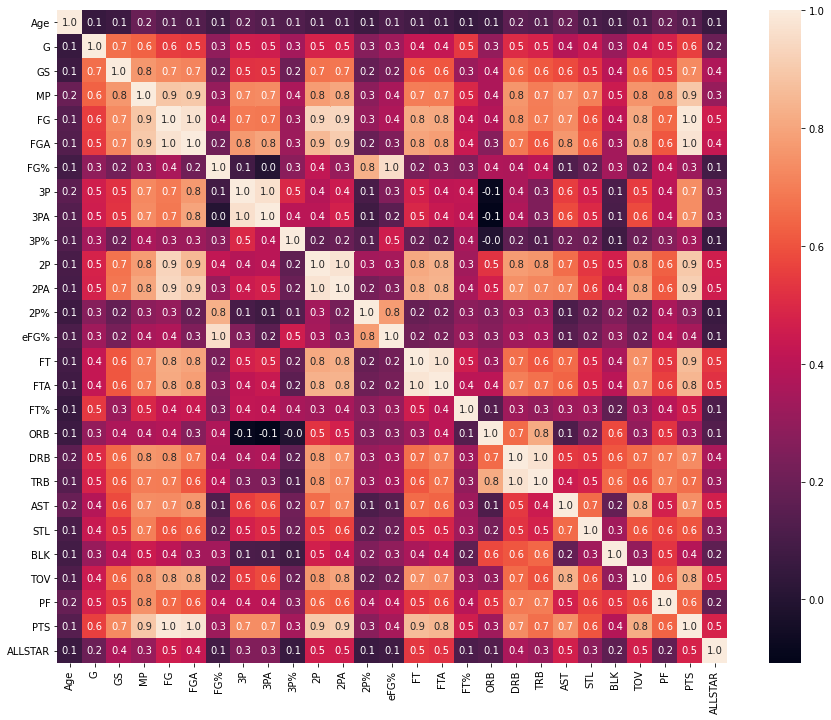

In [16]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(df.corr(), ax=ax, annot=True, fmt=".1f")

In [17]:
#sns.pairplot(df,hue="ALLSTAR")

In [18]:
def iqr(attribute): 
    return df[attribute].quantile(0.75) - df[attribute].quantile(0.25) 

def outliers(attribute):
    iqrange = iqr(attribute)
    lower_bound = df[attribute].quantile(0.25) -(1.5 * iqrange)
    upper_bound = df[attribute].quantile(0.75) +(1.5 * iqrange)
    return df[(df[attribute] > upper_bound) | (df[attribute] < lower_bound)]

Age

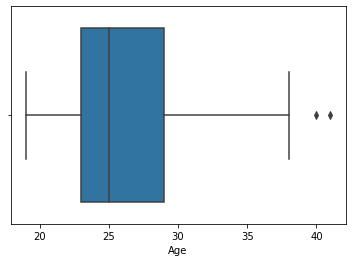

In [19]:
sns.boxplot('Age', data=df)

In [20]:
print("Number of outliers for age is: ",len(outliers('Age')))

Number of outliers for age is:  2


In [21]:
df['Age'].describe()

count    734.000000
mean      26.044959
std        4.092637
min       19.000000
25%       23.000000
50%       25.000000
75%       29.000000
max       41.000000
Name: Age, dtype: float64

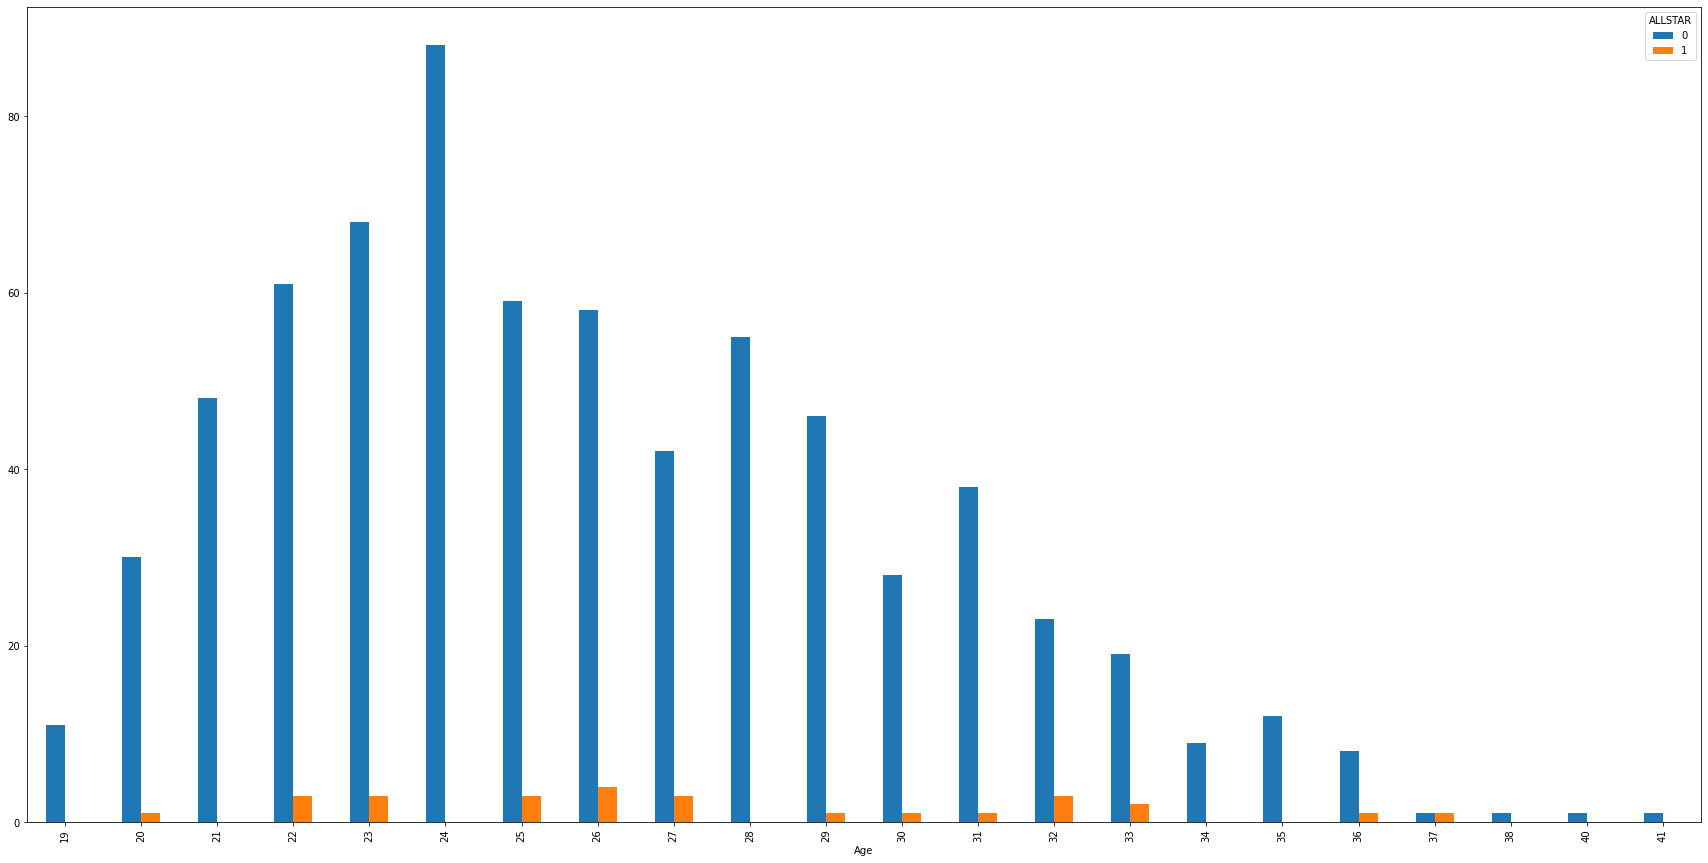

In [22]:
grouped=df.groupby(['ALLSTAR', 'Age'] )['Age'].count().unstack('ALLSTAR')
grouped.plot.bar(figsize=(30, 15))

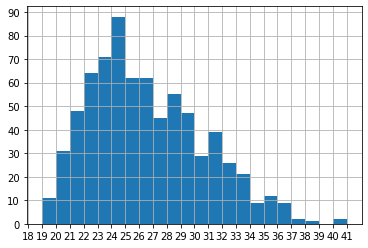

In [23]:
plt.xticks(np.arange(18, 42, 1))
plt.yticks(np.arange(0, 100, 10))
df['Age'].hist(bins=22)

In [24]:
stats.shapiro(df.Age)

ShapiroResult(statistic=0.9624007344245911, pvalue=8.798882846286493e-13)

Games

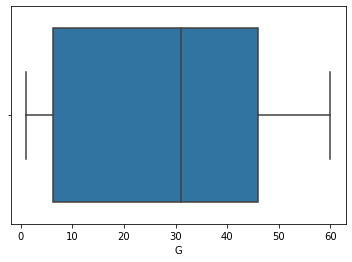

In [25]:
sns.boxplot('G', data=df)

In [26]:
print("Number of outliers for games played is: ",len(outliers('G')))

Number of outliers for games played is:  0


In [27]:
df['G'].describe()

count    734.000000
mean      28.279292
std       19.514704
min        1.000000
25%        6.250000
50%       31.000000
75%       46.000000
max       60.000000
Name: G, dtype: float64

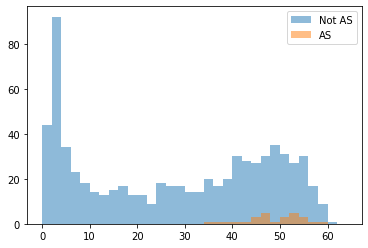

In [62]:
not_AS = df[df['ALLSTAR'] == 0]
a_stars = df[df['ALLSTAR'] == 1]

bins = np.arange(0, 66, 2)

plt.hist(not_AS['G'], bins, alpha=0.5, label='Not AS')
plt.hist(a_stars['G'], bins, alpha=0.5, label='AS')
plt.legend(loc='upper right')
plt.show()

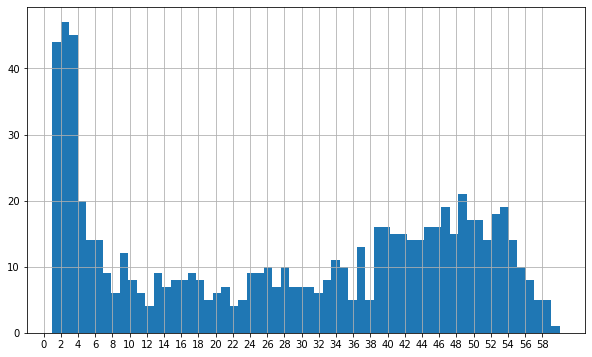

In [29]:
plt.xticks(np.arange(0, 60, 2))
plt.yticks(np.arange(0, 100, 10))
df['G'].hist(bins=60, figsize=(10, 6))

In [30]:
stats.shapiro(df.G)

ShapiroResult(statistic=0.8942295908927917, pvalue=4.815959728099254e-22)

Minutes

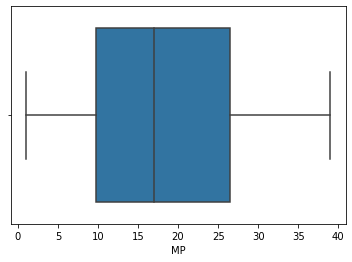

In [31]:
sns.boxplot('MP', data=df)

In [32]:
print("Number of outliers for minutes played is: ",len(outliers('MP')))

Number of outliers for minutes played is:  0


In [33]:
df['MP'].describe()

count    734.000000
mean      18.114169
std        9.995226
min        1.000000
25%        9.725000
50%       17.000000
75%       26.475000
max       39.000000
Name: MP, dtype: float64

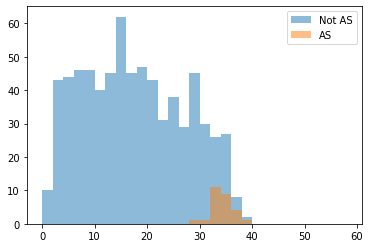

In [59]:
not_AS = df[df['ALLSTAR'] == 0]
a_stars = df[df['ALLSTAR'] == 1]

bins = np.arange(0, 60, 2)

plt.hist(not_AS['MP'], bins, alpha=0.5, label='Not AS')
plt.hist(a_stars['MP'], bins, alpha=0.5, label='AS')
plt.legend(loc='upper right')
plt.show()


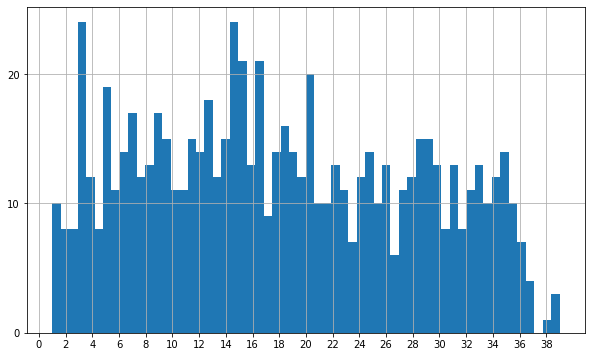

In [34]:
plt.xticks(np.arange(0, 40, 2))
plt.yticks(np.arange(0, 40, 10))
df['MP'].hist(bins=60, figsize=(10, 6))

In [24]:
stats.shapiro(df.MP)

ShapiroResult(statistic=0.9618173241615295, pvalue=6.708111713674136e-13)

Points per game

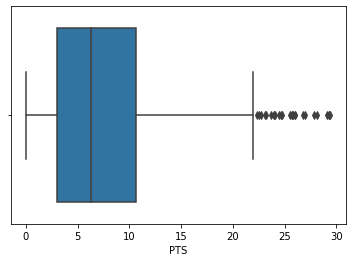

In [51]:
sns.boxplot('PTS', data=df)

In [52]:
print(outliers('PTS'))
print("Number of outliers for points scored is: ",len(outliers('PTS')))

                      Player Pos  Age   Tm   G  GS    MP    FG   FGA    FG%  \
Rk                                                                            
12     Giannis Antetokounmpo  PF   27  MIL  48  48  32.6  10.1  18.4  0.547   
40              Bradley Beal  SG   28  WAS  40  40  36.0   8.7  19.3  0.451   
58              Devin Booker  SG   25  PHO  51  51  34.1   9.3  20.8  0.446   
75              Jaylen Brown  SF   25  BOS  46  46  34.3   8.7  18.8  0.460   
124            Stephen Curry  PG   33  GSW  54  54  34.8   8.4  19.6  0.427   
125            Anthony Davis   C   28  LAL  37  37  35.1   9.2  17.2  0.537   
132            DeMar DeRozan  PF   32  CHI  55  55  35.6  10.3  19.9  0.517   
139              Luka Doncic  PG   22  DAL  43  43  35.4   9.6  21.3  0.448   
151             Kevin Durant  PF   33  BRK  36  36  36.5  10.5  20.3  0.520   
158              Joel Embiid   C   27  PHI  45  45  32.8   9.4  19.2  0.491   
183              Paul George  SF   31  LAC  26  26  

In [53]:
df['PTS'].describe()

count    734.000000
mean       7.727520
std        6.265428
min        0.000000
25%        3.000000
50%        6.300000
75%       10.675000
max       29.400000
Name: PTS, dtype: float64

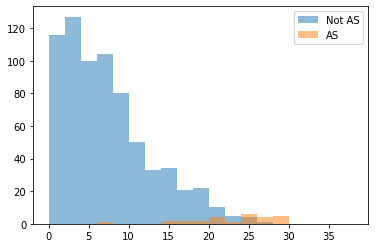

In [58]:
not_AS = df[df['ALLSTAR'] == 0]
a_stars = df[df['ALLSTAR'] == 1]

bins = np.arange(0, 40, 2)

plt.hist(not_AS['PTS'], bins, alpha=0.5, label='Not AS')
plt.hist(a_stars['PTS'], bins, alpha=0.5, label='AS')
plt.legend(loc='upper right')
plt.show()

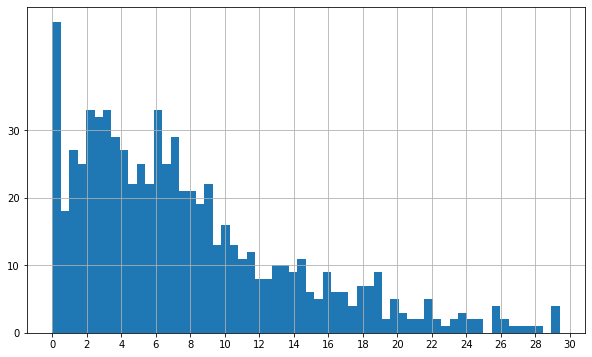

In [54]:
plt.xticks(np.arange(0, 35, 2))
plt.yticks(np.arange(0, 40, 10))
df['PTS'].hist(bins=60, figsize=(10, 6))

In [29]:
stats.shapiro(df.PTS)

ShapiroResult(statistic=0.9070057272911072, pvalue=9.656692263464443e-21)